# Fit multiple bambi models on longtogeny

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
)
from copy import deepcopy
from operator import or_
from tqdm.auto import tqdm
from toolz import reduce, valmap, keyfilter, pluck, dissoc, merge, compose
from aging.behavior.bio_age_model import fit_model, masked_xval, model_fun_v5, get_biological_age, compute_concentrations, concentration_interpolation, create_masks, expected_counts, compute_heldout_r2, model_setup, model_fun_v2
from scipy.spatial.distance import pdist, squareform

In [2]:
from sklearn.model_selection import ParameterSampler, ParameterGrid

In [3]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig5-death-predictor", tight_layout=False)

In [4]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

## Load the death predictor data

In [5]:
death_df = pd.read_csv('/home/wg41/code/ontogeny/notebooks/exploration/win/death-predictor/death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [6]:
def bin_age(df, bins):
    return pd.cut(df.reset_index()['age'], bins, labels=False)


def compute_correlations(df, bins, death_map, group_size=3):
    df = df.reset_index()
    corrs = []
    for i in range(group_size):
        for bin, _df in df.groupby((bins + i) // group_size, observed=True):

            avgs = _df.groupby('mouse')[['beh_age', 'date', 'age']].mean()

            joined = avgs.join(death_map)
            _corr = joined.corr(method='spearman').loc[['beh_age'], ['Death']]
            # _corr = joined.corr(method='pearson').loc[['beh_age'], ['Death']]

            # joined['bar'] = joined['beh_age'].rank()
            # _corr = joined.corr(method='pearson').loc[['bar'], ['death_rank']]

            _corr.index = pd.Index([joined['age'].mean()], name='age')
            _corr['bin'] = (bin * group_size) + i

            corrs.append(_corr)
    return pd.concat(corrs).sort_index()


def compute_shuffled_correlations(df, bins, death_map, group_size=3, seed=None):
    df_copy = df.reset_index()
    death_map = death_map.copy()
    # death_map['Death'] = death_map['Death'].sample(frac=1, random_state=seed).to_numpy()
    # death_map['death_rank'] = death_map['death_rank'].sample(frac=1, random_state=seed).to_numpy()

    corrs = []
    for i in range(group_size):
        # shuffling happens here
        df_copy['beh_age'] = df.groupby((bins + i) // group_size, observed=True)['beh_age'].transform(lambda x: x.sample(frac=1, random_state=seed).to_numpy())
        # df_copy['beh_age'] = df['beh_age'].sample(frac=1, random_state=seed).to_numpy()
        # df_copy['beh_age'] = df.groupby('mouse')['beh_age'].transform(lambda x: x.sample(frac=1, random_state=seed).to_numpy())

        for bin, _df in df_copy.groupby((bins + i) // group_size, observed=True):

            avgs = _df.groupby('mouse')[['beh_age', 'date', 'age']].mean()

            joined = avgs.join(death_map)
            _corr = joined.corr(method='spearman').loc[['beh_age'], ['Death']]
            # _corr = joined.corr(method='pearson').loc[['beh_age'], ['Death']]

            # joined['bar'] = joined['beh_age'].rank()
            # _corr = joined.corr(method='pearson').loc[['bar'], ['death_rank']]

            _corr.index = pd.Index([joined['age'].mean()], name='age')
            _corr['bin'] = (bin * group_size) + i

            corrs.append(_corr)
    return pd.concat(corrs).sort_index()

In [7]:
to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

In [8]:
def load_long_df(n_bins: "Optional[int]" = 75):
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[keep_syllables]
    mask = df.index.get_level_values("age") < 100
    df = df[mask].copy()

    masks = []
    for uuid in to_remove:
        m = df.reset_index()['uuid'].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
    )
    mask = size_df.index.get_level_values("age") < 100
    size_df = size_df[mask].copy()
    age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

    size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
    sizes_col = size_df['quant_0.5']
    sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

    # sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
    sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
    sizes_col = sizes_col.fillna(0)
    sizes_col = sizes_col.loc[df.index]

    # make sure df matches sizes
    df = df.loc[sizes_col.index]

    if n_bins is not None:
        # subsample the dataset
        cut, bins = pd.cut(df.index.get_level_values('age'), n_bins, retbins=True)
        # tmp_df = df.groupby(['mouse', cut], observed=True).first()
        tmp_df = df.reset_index().groupby(['mouse', cut], observed=True).first().reset_index().drop(columns=['level_1']).set_index(['age', 'mouse', 'subject_name', "session_name", 'uuid', 'date'])
        # mid_age = [round(v.left, 2) for v in tmp_df.index.get_level_values(1)]
        # tmp_df['age'] = mid_age
        # tmp_df = tmp_df.set_index('age', append=True).droplevel(1)

        sizes_col = sizes_col.reset_index().groupby(['mouse', cut], observed=True).first()
        sizes_col = sizes_col.reset_index().drop(columns=['level_1']).set_index(['age', 'mouse', 'subject_name', "session_name", 'uuid', 'date'])
        sizes_col = sizes_col.loc[tmp_df.index, 'quant_0.5']
    else:
        tmp_df = df

    age = jnp.array(tmp_df.index.get_level_values("age"))
    syllable_counts_jax = jnp.array(tmp_df.astype(float))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx

In [9]:
tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx = load_long_df(None)

In [89]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    "mice": mouse_ids,  # models > 2
}

hypparams = {
    "min_age": 1,
    # "max_age": 100,
    "max_age": int(age.max() + 5),
    "age_sd": 9,  # weeks
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.2,
    "n_opt_iter": 400,
}

In [17]:
def minimizer(corrs):
    return corrs['Death'].iloc[-11:].mean()

In [13]:
bins, _bins = pd.cut(tmp_df.reset_index()['age'], 28, labels=False, retbins=True)

In [65]:
mdl = fit_model(features, hypparams, 5)

In [66]:
tmp_df['beh_age'] = mdl['bio_ages']

In [67]:
corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=4)

In [69]:
minimizer(corrs)

-0.25072850317746304

In [104]:
# define parameter grid
# this was the first version - now I have a better sense of the parameters to try
# grid = {
#     'age_sd': np.arange(1, 30, 3) + 0.01,
#     'n_splines': np.arange(4, 7, dtype=int),
#     'n_development_splines': np.arange(4, 8, dtype=int),
#     'scale': np.arange(50, 501, 50),
# }
# v2 - more targeted
# grid = {
#     'age_sd': np.arange(2, 15) + 0.01,
#     'n_development_splines': np.arange(4, 8, dtype=int),
#     'scale': np.arange(100, 401, 25, dtype=int),
# }
# v3 - more targeted
grid = {
    'age_sd': np.linspace(2, 5, 12),
    'n_development_splines': [5, 7],
    'scale': np.arange(300, 450, 20, dtype=int),
}

In [91]:
list(mdl)

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'age_likelihoods',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each']

## Run a series of grids

In [92]:
import random

In [105]:
bins, _bins = pd.cut(tmp_df.reset_index()['age'], 28, labels=False, retbins=True)

random.seed(0)
pg = list(ParameterGrid(grid))
random.shuffle(pg)

min_correlation = np.inf

pbar = tqdm(pg)

out = []
for params in pbar:
    # remove the numpy class from scalars
    params = valmap(float, params)
    params['n_development_splines'] = int(params['n_development_splines'])
    new_hypparams = merge(hypparams, params)
    try:
        tmp_mdl = fit_model(features, new_hypparams, 5)
        # tmp_mdl = masked_xval(features, new_hypparams, 5, n_repeats=3, disable_tqdm=True)
        # params['heldout_ll'] = np.mean(list(pluck('heldout_ll', tmp_mdl.values())))
        # params['heldout_r2'] = np.mean(list(pluck('heldout_r2_total_v3', tmp_mdl.values())))

        # bio_ages = np.mean(list(pluck('bio_ages', tmp_mdl.values())), axis=0)
        tmp_df['beh_age'] = tmp_mdl['bio_ages']
        corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=4)
        params['death_corr'] = minimizer(corrs)

        if params['death_corr'] < min_correlation:
            pbar.set_description(f"{params['death_corr']:0.2f}")
            min_correlation = params['death_corr']

        out.append(params)
        print(params)
    except ValueError:
        pass

  0%|          | 0/192 [00:00<?, ?it/s]

{'age_sd': 3.909090909090909, 'n_development_splines': 5, 'scale': 400.0, 'death_corr': -0.38975841294673547}
{'age_sd': 4.181818181818182, 'n_development_splines': 5, 'scale': 420.0, 'death_corr': -0.37951556379539575}
{'age_sd': 4.727272727272727, 'n_development_splines': 5, 'scale': 340.0, 'death_corr': -0.3545208620991441}
{'age_sd': 4.727272727272727, 'n_development_splines': 5, 'scale': 440.0, 'death_corr': -0.3600915235087289}
{'age_sd': 4.181818181818182, 'n_development_splines': 5, 'scale': 440.0, 'death_corr': -0.38045693371624556}
{'age_sd': 2.5454545454545454, 'n_development_splines': 5, 'scale': 300.0, 'death_corr': 0.24987898213635723}
{'age_sd': 3.909090909090909, 'n_development_splines': 7, 'scale': 360.0, 'death_corr': -0.28326363522897197}
{'age_sd': 3.090909090909091, 'n_development_splines': 5, 'scale': 320.0, 'death_corr': 0.2580846992155995}
{'age_sd': 4.181818181818182, 'n_development_splines': 7, 'scale': 320.0, 'death_corr': -0.5011939662290137}
{'age_sd': 3.36

KeyboardInterrupt: 

In [106]:
opt_df = pd.DataFrame(out)

In [107]:
opt_df.head()

,age_sd,n_development_splines,scale,death_corr
0,3.909091,5,400.0,-0.389758
1,4.181818,5,420.0,-0.379516
2,4.727273,5,340.0,-0.354521
3,4.727273,5,440.0,-0.360092
4,4.181818,5,440.0,-0.380457


In [108]:
opt_df.to_parquet('/n/scratch/users/w/wg41/death-predictor-params-v3.parquet')

In [109]:
sorted_opt_df = opt_df.sort_values(by='death_corr')
sorted_opt_df

,age_sd,n_development_splines,scale,death_corr
8,4.181818,7,320.0,-0.501194
53,3.909091,7,440.0,-0.445483
24,3.636364,5,400.0,-0.432959
34,3.636364,5,380.0,-0.432217
33,3.909091,5,360.0,-0.410985
...,...,...,...,...
57,3.363636,7,300.0,0.489053
27,2.818182,7,340.0,0.497067
54,2.545455,7,380.0,0.499743
29,2.818182,7,360.0,0.499859


<Axes: xlabel='scale', ylabel='age_sd'>

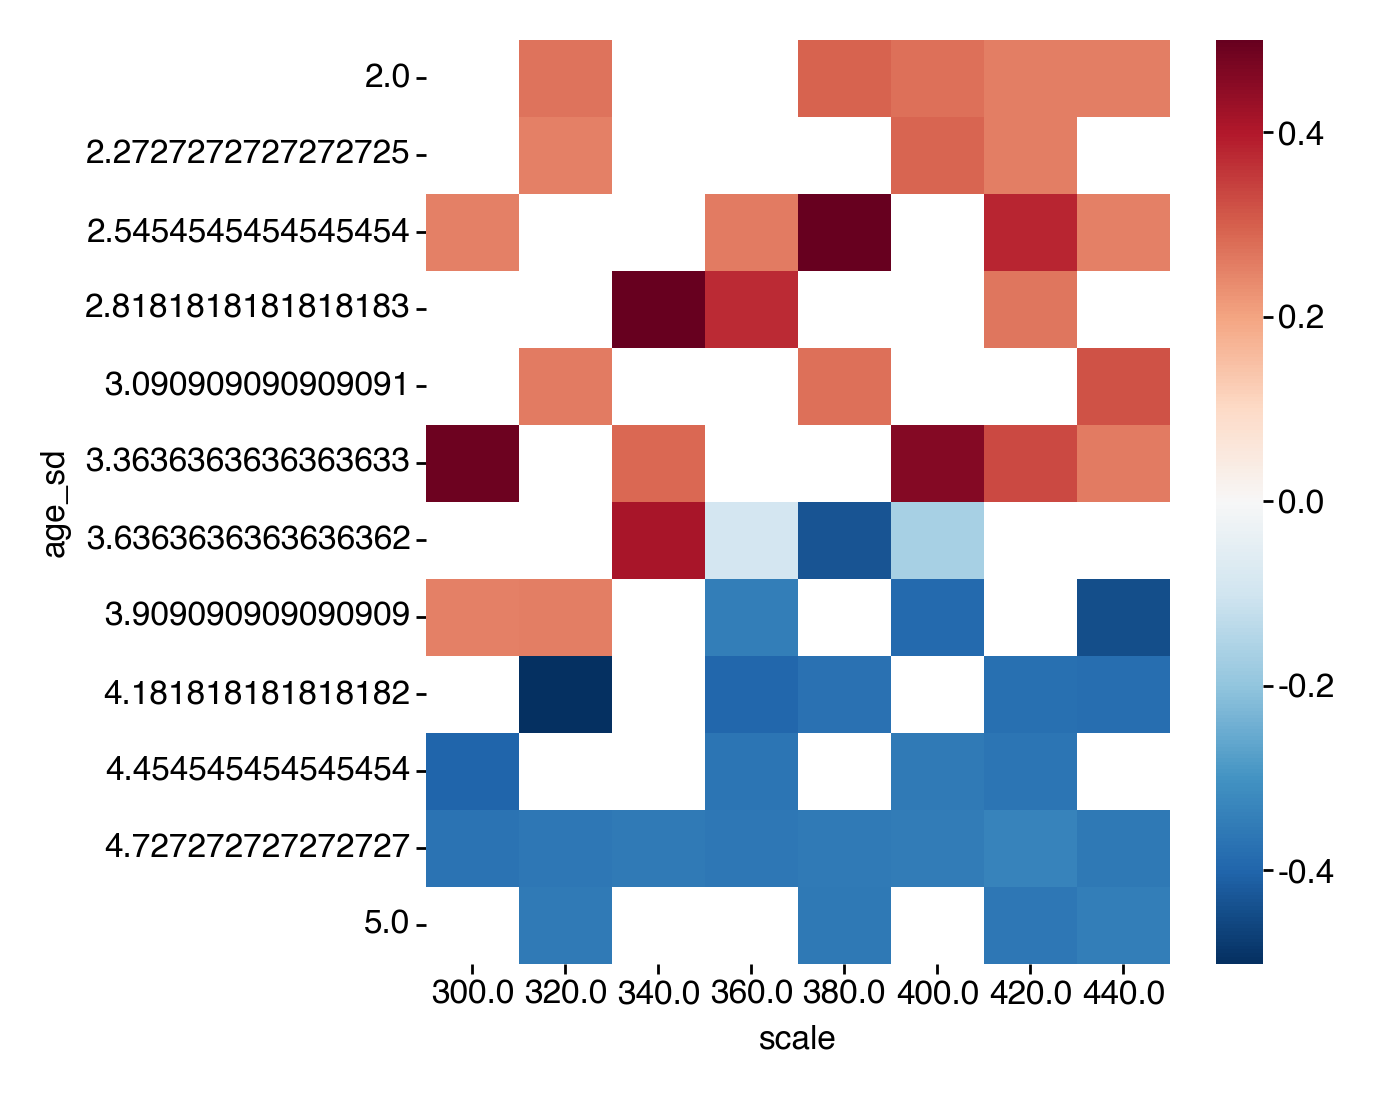

In [110]:
sns.heatmap(pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr'), cmap='RdBu_r', center=0)

<Axes: xlabel='scale', ylabel='n_development_splines'>

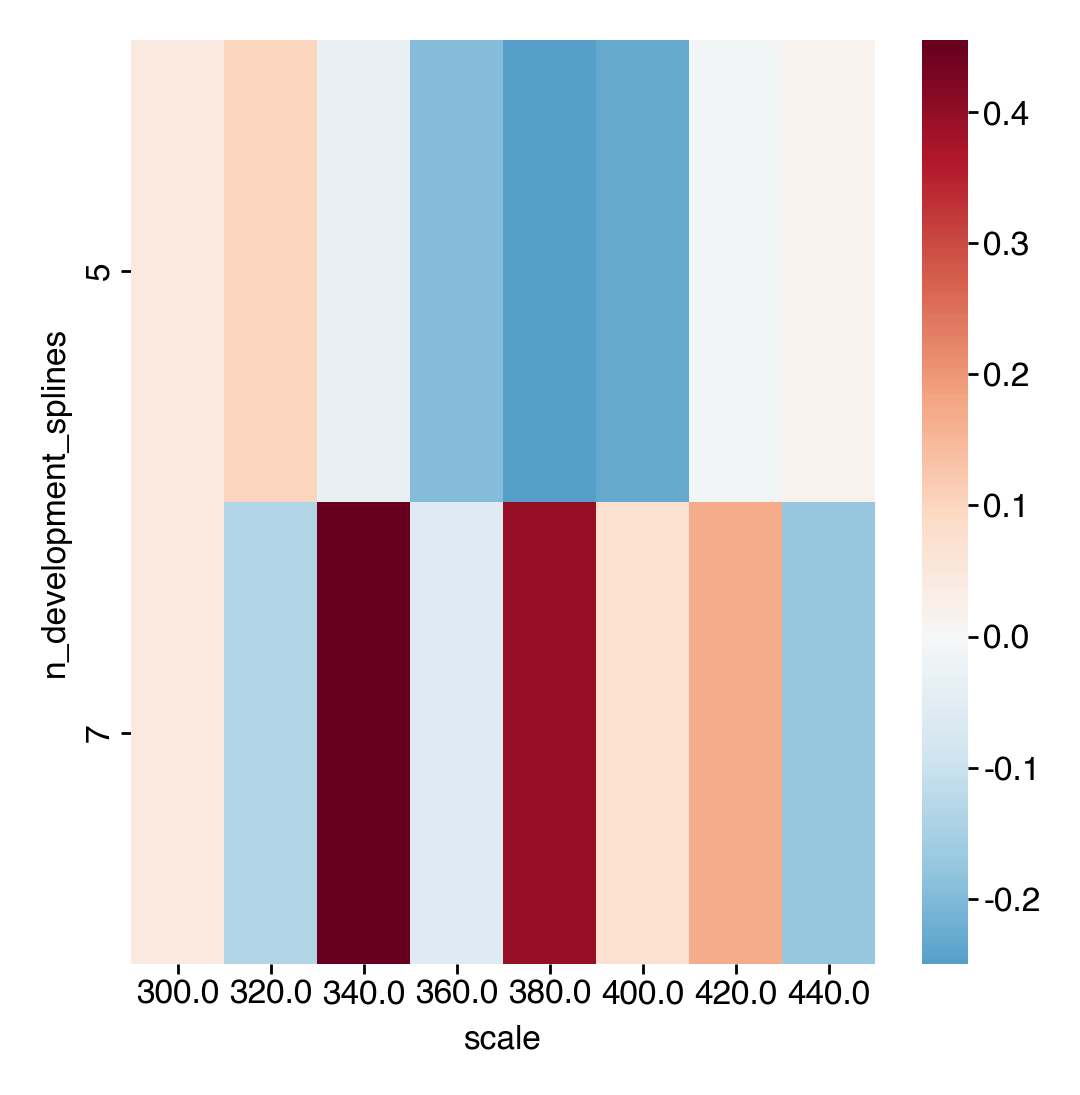

In [111]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='scale', values='death_corr'), cmap='RdBu_r', center=0)

<Axes: xlabel='age_sd', ylabel='n_development_splines'>

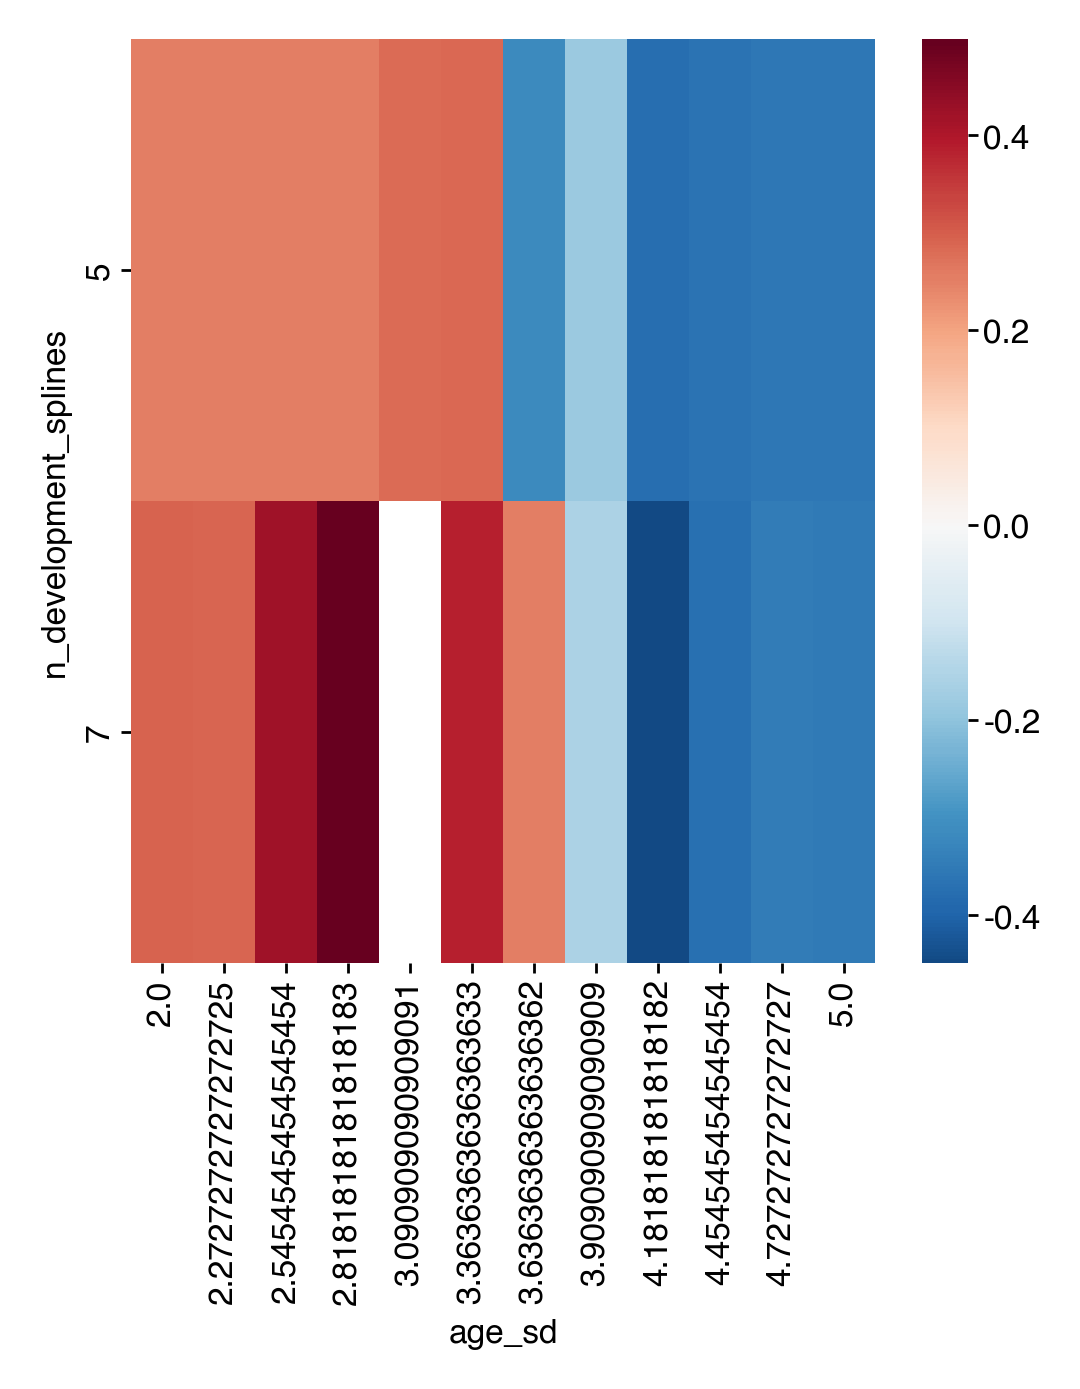

In [112]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='age_sd', values='death_corr'), cmap='RdBu_r', center=0)

<Axes: xlabel='scale', ylabel='age_sd'>

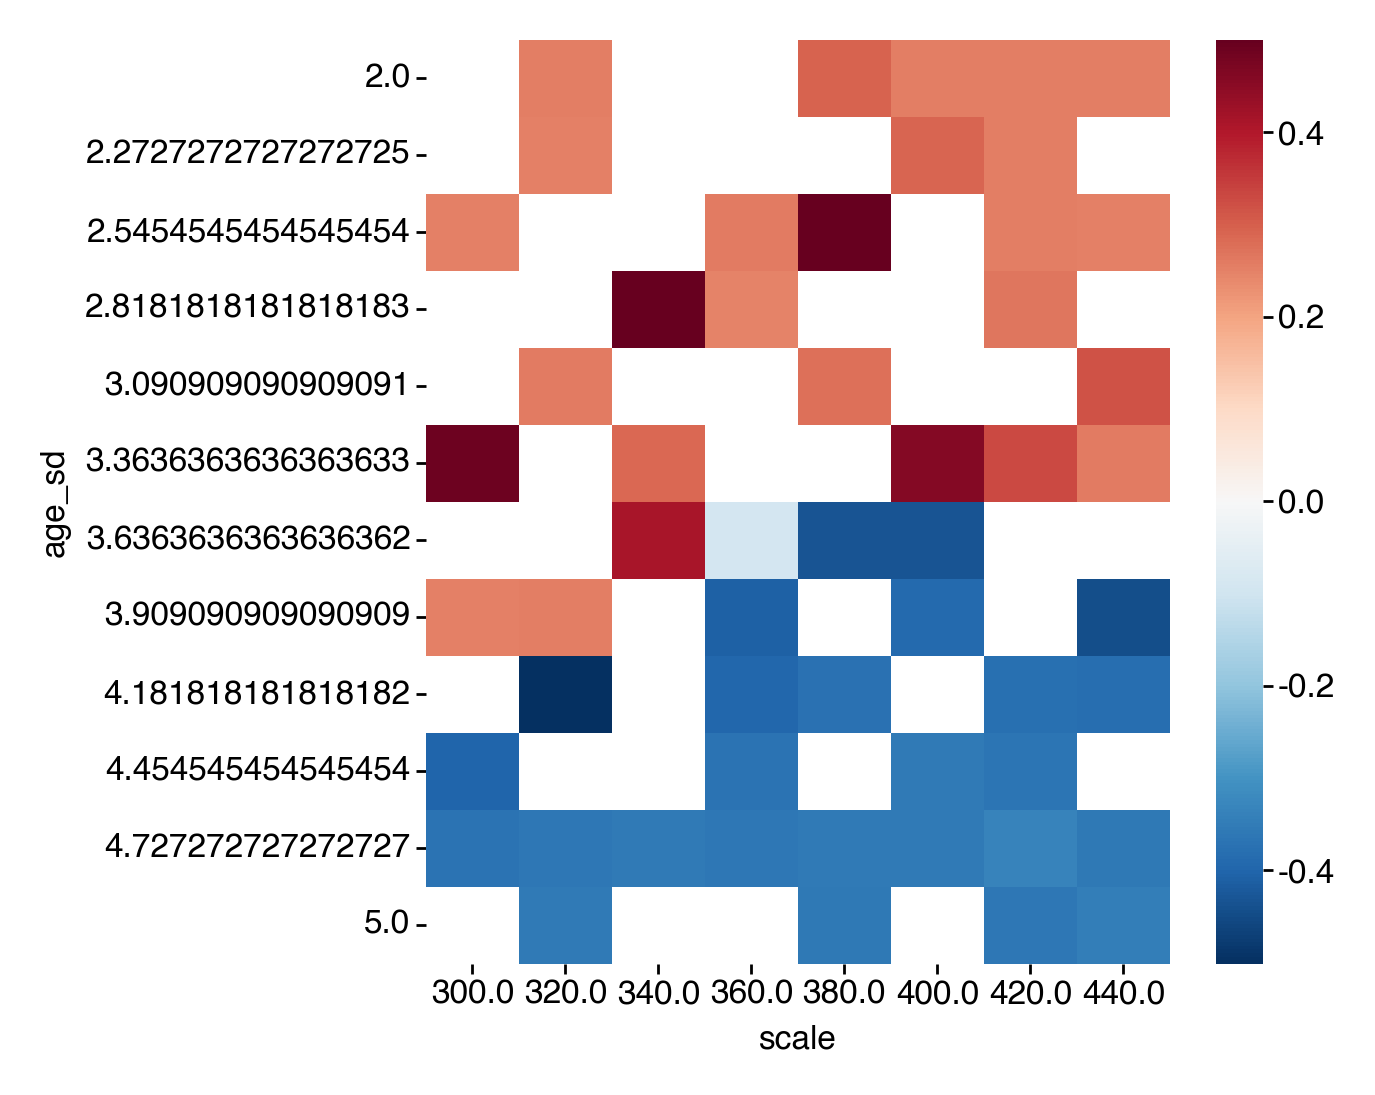

In [113]:
sns.heatmap(pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr', aggfunc='min'), cmap='RdBu_r', center=0)

<Axes: xlabel='age_sd', ylabel='n_development_splines'>

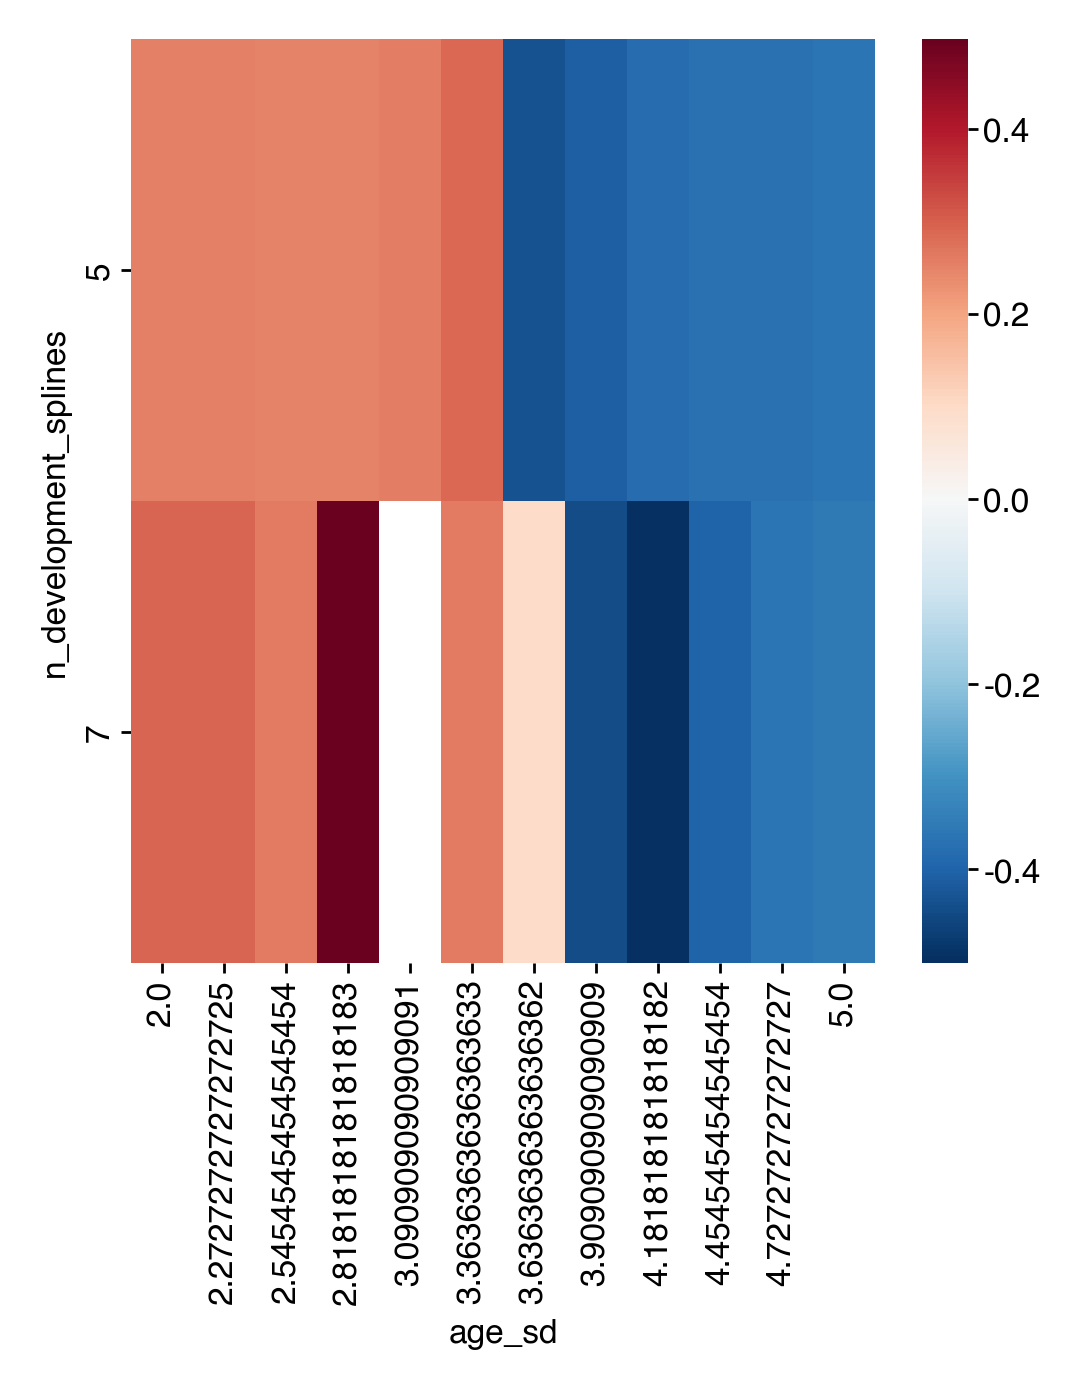

In [114]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='age_sd', values='death_corr', aggfunc='min'), cmap='RdBu_r', center=0)

In [107]:
params = opt_df.loc[sorted_opt_df.index[0]].iloc[:4]
new_hypparams = merge(hypparams, valmap(int, dict(params)))

In [108]:
mdl = fit_model(features, new_hypparams, 5)

In [109]:
tmp_df['beh_age'] = mdl['bio_ages']

In [130]:
bins, _bins = pd.cut(tmp_df.reset_index()['age'], 32, labels=False, retbins=True)
corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=8)
minimizer(corrs)

-0.3868757539187919

<Axes: xlabel='age'>

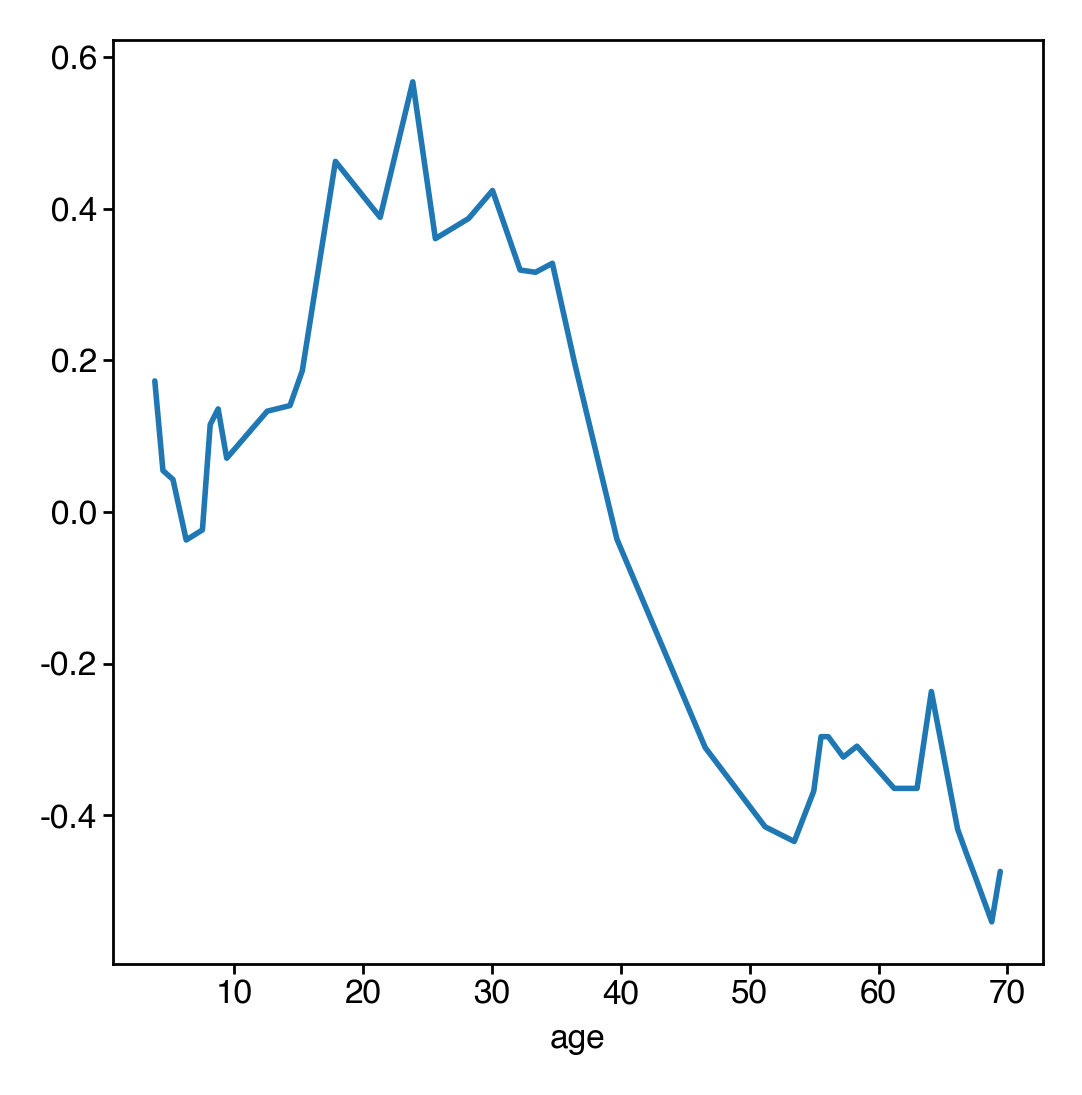

In [131]:
corrs['Death'].plot()

## Load parameter data, analyze model outputs in detail

In [11]:
opt_df = pd.read_parquet('/n/scratch/users/w/wg41/death-predictor-params.parquet')


In [27]:
sorted_opt_df = opt_df.sort_values(by='death_corr')
sorted_opt_df.head(20)

,age_sd,n_development_splines,n_splines,scale,death_corr
466,4,7,4,350,-0.488752
396,4,7,4,400,-0.481715
183,7,5,5,250,-0.420563
367,7,7,5,250,-0.416198
360,4,5,4,350,-0.401646
151,4,5,4,400,-0.387523
40,4,7,4,500,-0.381075
343,7,5,4,150,-0.352254
592,16,5,5,50,-0.347724
547,7,7,4,150,-0.345608


In [46]:
params = opt_df.loc[sorted_opt_df.index[0]].iloc[:4]
params = valmap(int, dict(params))

In [47]:
new_hypparams = merge(hypparams, params)

In [38]:
mdl = fit_model(features, new_hypparams, 5)

In [39]:
tmp_df['beh_age'] = mdl['bio_ages']

In [40]:
bins, _bins = pd.cut(tmp_df.reset_index()['age'], 28, labels=False, retbins=True)
corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=4)
minimizer(corrs)

-0.4887517804394961

<Axes: xlabel='age'>

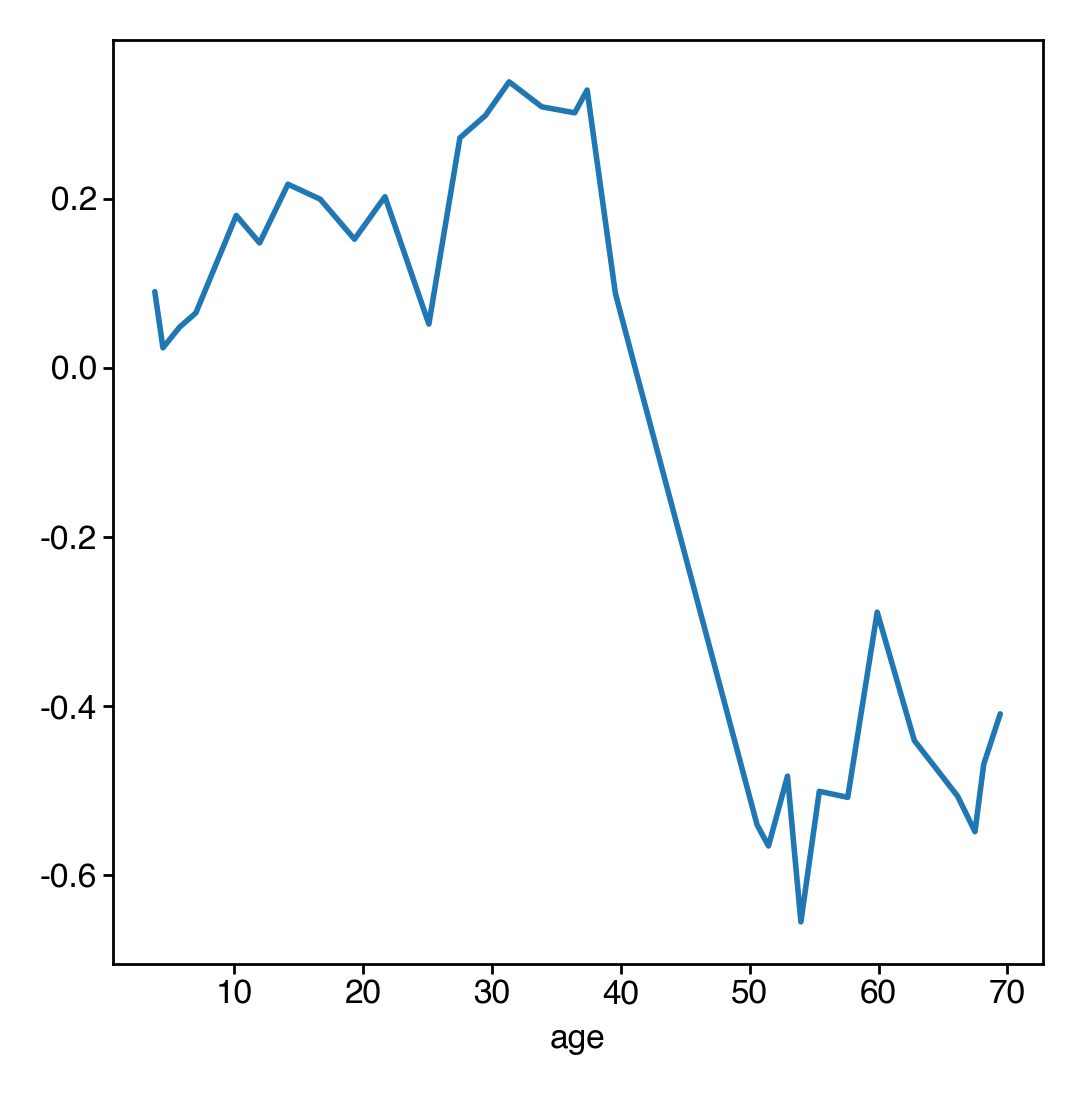

In [41]:
corrs['Death'].plot()

In [42]:
list(mdl['params'])

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

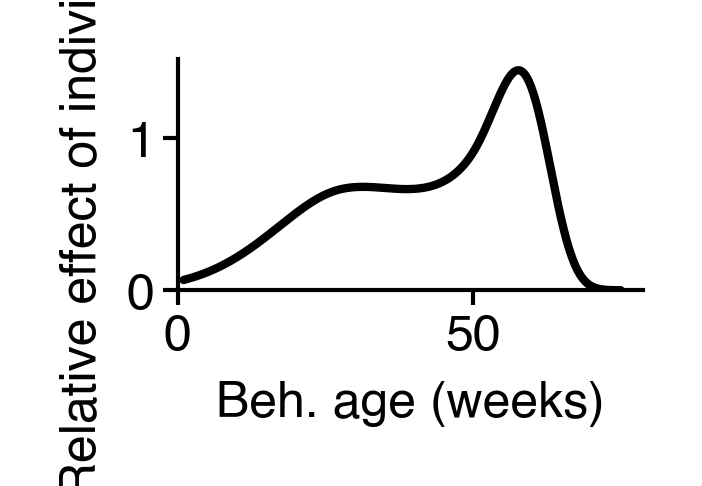

In [76]:
x = mdl['params']['development_weights']
dev = (x @ mdl['init_components'].bases['development']).squeeze()

comps = mdl['init_components']

dev = np.exp(dev)

fig = figure(1, 0.5)
plt.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of individuality")
sns.despine()

### Playing with parameters

In [115]:
params['n_splines'] = 4
params['age_sd'] = 4
params['scale'] = 375
params['n_development_splines'] = 7  # or 5

In [116]:
new_hypparams = merge(hypparams, params)

In [ ]:
mdl = fit_model(features, new_hypparams, 5)
tmp_df['beh_age'] = mdl['bio_ages']

In [ ]:
from scipy.stats import spearmanr
from toolz import sliding_window

In [222]:
def compute_correlations_v2(df, win_size=16):
    reset_df = df.reset_index()

    sliding_corr_df = []

    for w in sliding_window(win_size, range(3, 71)):
        subset = reset_df[(reset_df["age"] >= w[0]) & (reset_df["age"] <= w[-1])]
        subset_join = subset.merge(
            death_map.reset_index(), left_on="mouse", right_on="id"
        ).dropna(subset=["Death"])

        # proven that this gives the same result as casting the datetime to int
        res = spearmanr(subset_join["beh_age"], subset_join["Death"].rank(method="min"))
        sliding_corr_df.append(
            dict(
                corr=res.correlation,
                p=res.pvalue,
                start=w[0],
                stop=w[-1],
                avg=subset["age"].mean(),
                n_samples=len(subset),
            )
        )
    sliding_corr_df = pd.DataFrame(sliding_corr_df)
    return sliding_corr_df

In [223]:
sliding_corr_df = compute_correlations_v2(tmp_df, win_size=16)

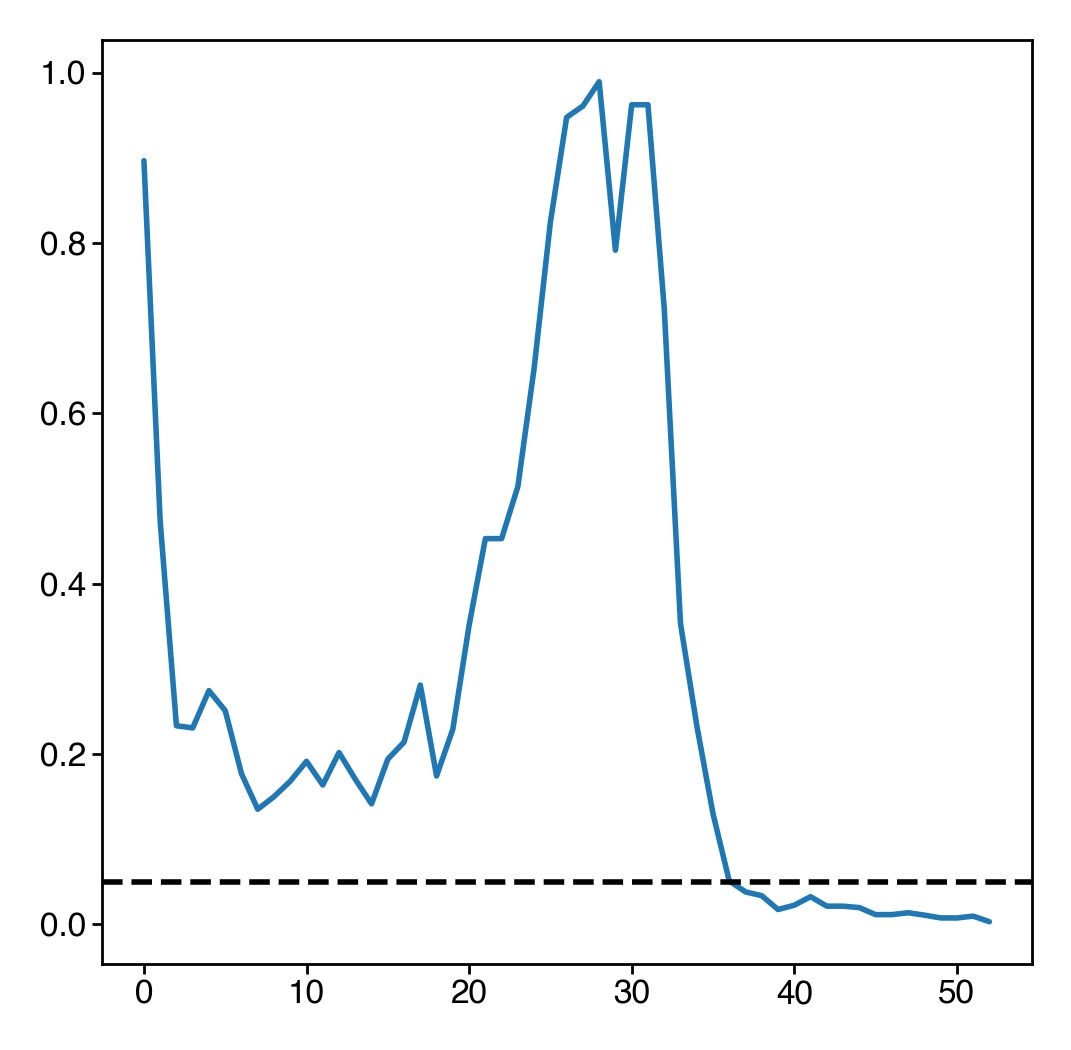

In [224]:
ax = sliding_corr_df['p'].plot()
ax.axhline(0.05, color='k', ls='--')

<Axes: >

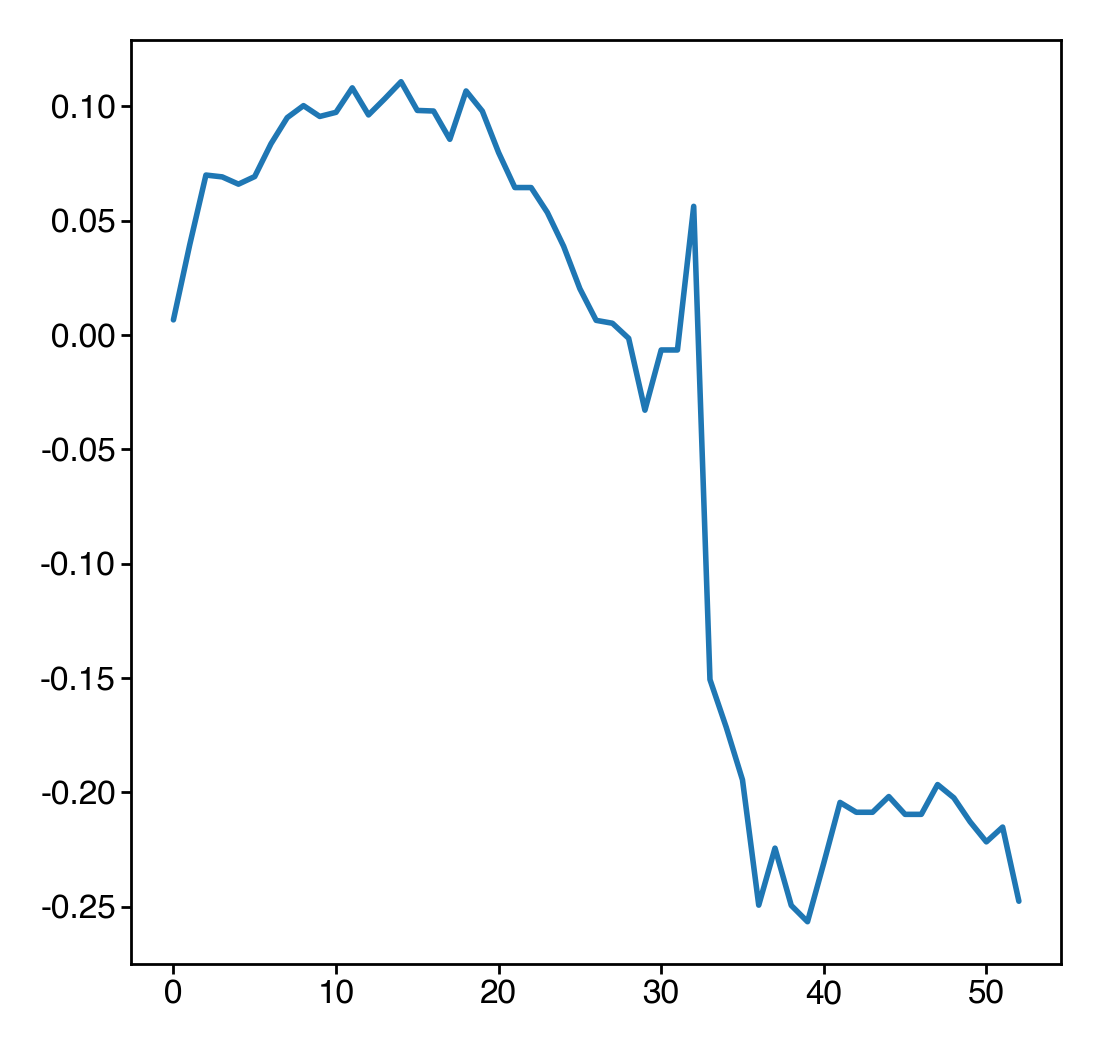

In [225]:
sliding_corr_df['corr'].plot()

## Make correlation plots 